In [1]:
#S'assurer que la bonne version (3.11) de python est utilisé 
import sys
print(sys.version)

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [2]:
#Importer les bibliothèques PyCATSHOO 
from PyCaUtils import *  

In [3]:
class ITLoad(Pyc.CComponent):
    """
    ITLoad : génère une charge thermique variable (kW) selon un cycle principal + une petite ondulation.
    Modèle A : Load(t)=L0*(1+a*sin(2πt/P)) + (b*L0)*sin(2πt/P2)
    """

    def __init__(self, name):
        Pyc.CComponent.__init__(self, name)

        # ===== Paramètres =====
        # Charge moyenne (kW)
        self.p_baseLoad = self.addVariable("baseLoad", Pyc.TVarType.t_double, 700.0)

        # Amplitude relative du cycle principal (ex: 0.2 = ±20%)
        self.p_ampMain = self.addVariable("ampMain", Pyc.TVarType.t_double, 0.20)

        # Période du cycle principal (unités de temps de simulation)
        # ex: 24 si 1 unité = 1 heure
        self.p_periodMain = self.addVariable("periodMain", Pyc.TVarType.t_double, 24.0)

        # Amplitude relative de la petite ondulation (ex: 0.05 = ±5%)
        self.p_ampSmall = self.addVariable("ampSmall", Pyc.TVarType.t_double, 0.05)

        # Période de la petite ondulation (unités de temps de simulation)
        self.p_periodSmall = self.addVariable("periodSmall", Pyc.TVarType.t_double, 2.0)

        # Bornes (sécurité numérique / sens physique)
        self.p_minLoad = self.addVariable("minLoad", Pyc.TVarType.t_double, 0.0)
        self.p_maxLoad = self.addVariable("maxLoad", Pyc.TVarType.t_double, 2000.0)

        # ===== Variable =====
        self.v_load = self.addVariable("load", Pyc.TVarType.t_double, 0.0)

        # ===== MessageBox (export vers le reste du modèle) =====
        self.addMessageBox("MB_OUT")
        self.addMessageBoxExport("MB_OUT", self.v_load, "load")

        # ===== PDMP : variable explicite =====
        self.addPDMPManager("PDMP-Manager")
        self.addPDMPExplicitVariable("PDMP-Manager", self.v_load)
        self.addPDMPEquationMethod("PDMP-Manager", "equationMethod", self.equationMethod)

        # Initialisation
        self.addStartMethod("startMethod", self.startMethod)

    def startMethod(self):
        # Au démarrage, on met la charge à la valeur moyenne
        self.v_load.setDValue(self.p_baseLoad.dValue())

    def equationMethod(self):
        t = self.currentTime()

        L0 = self.p_baseLoad.dValue()
        a  = self.p_ampMain.dValue()
        P  = self.p_periodMain.dValue()

        b  = self.p_ampSmall.dValue()
        P2 = self.p_periodSmall.dValue()

        # Cycle principal (jour/nuit, activité globale)
        main = L0 * (1.0 + a * np.sin(2.0 * np.pi * t / P))

        # Petite ondulation (variations courtes : jobs, pics locaux, fluctuations)
        small = (b * L0) * np.sin(2.0 * np.pi * t / P2)

        load = main + small

        # Bornage
        load = max(self.p_minLoad.dValue(), min(load, self.p_maxLoad.dValue()))

        self.v_load.setDValue(load)

In [4]:
class OutdoorAir(Pyc.CComponent):
    """
    OutdoorAir : génère la température extérieure (°C) avec :
      - un cycle journalier (sinusoïdal)
      - un épisode de canicule avec montée/descente progressive (rampe)

    Modèle :
      Tnormal(t) = T0 + A*sin(2πt/P)
      Tout(t)    = Tnormal(t) + w(t)*ΔT
    où w(t) ∈ [0,1] est une pondération lissée pendant la canicule :
      - montée linéaire sur rampDuration
      - plateau
      - descente linéaire sur rampDuration
    """

    def __init__(self, name):
        Pyc.CComponent.__init__(self, name)

        # ===== Paramètres : climat "normal" =====
        # Température moyenne (°C)
        self.p_baseTout = self.addVariable("baseTout", Pyc.TVarType.t_double, 25.0)

        # Amplitude jour/nuit (°C) : variation ±ampDaily
        self.p_ampDaily = self.addVariable("ampDaily", Pyc.TVarType.t_double, 5.0)

        # Période du cycle (unités de temps simulation)
        # ex: 24 si 1 unité = 1 heure
        self.p_period = self.addVariable("period", Pyc.TVarType.t_double, 24.0)

        # ===== Paramètres : canicule =====
        # Surélévation de température (°C) pendant la canicule (au plateau)
        self.p_heatwaveDelta = self.addVariable("heatwaveDelta", Pyc.TVarType.t_double, 10.0)

        # Début et fin de la canicule (unités de temps simulation)
        self.p_heatwaveStart = self.addVariable("heatwaveStart", Pyc.TVarType.t_double, 30.0)
        self.p_heatwaveEnd   = self.addVariable("heatwaveEnd",   Pyc.TVarType.t_double, 60.0)

        # Durée de montée et de descente progressive (rampe)
        # ex: 6 si 1 unité = 1 heure => 6h de transition
        self.p_rampDuration = self.addVariable("rampDuration", Pyc.TVarType.t_double, 6.0)

        # ===== Bornes physiques (sécurité) =====
        self.p_minTout = self.addVariable("minTout", Pyc.TVarType.t_double, -10.0)
        self.p_maxTout = self.addVariable("maxTout", Pyc.TVarType.t_double, 50.0)

        # ===== Variable d'état =====
        self.v_Tout = self.addVariable("Tout", Pyc.TVarType.t_double, 0.0)

        # ===== MessageBox : export vers le reste du modèle =====
        self.addMessageBox("MB_OUT")
        self.addMessageBoxExport("MB_OUT", self.v_Tout, "Tout")

        # ===== PDMP : variable explicite =====
        self.addPDMPManager("PDMP-Manager")
        self.addPDMPExplicitVariable("PDMP-Manager", self.v_Tout)
        self.addPDMPEquationMethod("PDMP-Manager", "equationMethod", self.equationMethod)

        # ===== Initialisation =====
        self.addStartMethod("startMethod", self.startMethod)

    def startMethod(self):
        # Initialiser la température à la moyenne
        self.v_Tout.setDValue(self.p_baseTout.dValue())

    def equationMethod(self):
        t = self.currentTime()

        # --- Température normale jour/nuit ---
        T0 = self.p_baseTout.dValue()
        A  = self.p_ampDaily.dValue()
        P  = self.p_period.dValue()

        Tnormal = T0 + A * np.sin(2.0 * np.pi * t / P)

        # --- Canicule lissée via w(t) ---
        tS   = self.p_heatwaveStart.dValue()
        tE   = self.p_heatwaveEnd.dValue()
        dT   = self.p_heatwaveDelta.dValue()
        ramp = self.p_rampDuration.dValue()

        w = 0.0
        if tS <= t <= tE:
            # Cas dégénéré : rampe nulle ou incohérente
            if ramp <= 0:
                w = 1.0
            else:
                # Si la canicule est trop courte pour faire montée+descente,
                # on ajuste implicitement : le plateau disparaît.
                # (On garde une forme "triangle" au lieu d'un trapèze.)
                if (tE - tS) < 2.0 * ramp:
                    mid = 0.5 * (tS + tE)
                    if t <= mid:
                        w = (t - tS) / max(1e-12, (mid - tS))
                    else:
                        w = (tE - t) / max(1e-12, (tE - mid))
                else:
                    # Montée
                    if t < (tS + ramp):
                        w = (t - tS) / ramp
                    # Descente
                    elif t > (tE - ramp):
                        w = (tE - t) / ramp
                    # Plateau
                    else:
                        w = 1.0

            # sécurité numérique
            w = max(0.0, min(w, 1.0))

        # Température extérieure totale
        Tout = Tnormal + w * dT

        # --- Bornage physique ---
        Tout = max(self.p_minTout.dValue(), min(Tout, self.p_maxTout.dValue()))

        # Mise à jour
        self.v_Tout.setDValue(Tout)

In [5]:
class Condenser(Pyc.CComponent):
    """
    Condenser : système de rejet de chaleur.
    Transforme la température extérieure Tout (°C)
    en une efficacité de rejet eta (0..1).
    """

    def __init__(self, name):
        Pyc.CComponent.__init__(self, name)

        # ===== Paramètres thermiques =====
        # Température extérieure nominale (fonctionnement optimal)
        self.p_Tnom = self.addVariable("Tnom", Pyc.TVarType.t_double, 25.0)

        # Température critique (dégradation maximale)
        self.p_Tcrit = self.addVariable("Tcrit", Pyc.TVarType.t_double, 45.0)

        # Efficacité minimale atteignable
        self.p_etaMin = self.addVariable("etaMin", Pyc.TVarType.t_double, 0.6)

        # ===== Paramètres de fiabilité =====
        self.p_lambda = self.addVariable("lambda", Pyc.TVarType.t_double, 1e-4)
        self.p_mu     = self.addVariable("mu",     Pyc.TVarType.t_double, 1e-2)

        # ===== Référence (entrée) =====
        self.r_Tout = self.addReference("Tout")

        # ===== Variable d’état (sortie) =====
        self.v_eta = self.addVariable("eta", Pyc.TVarType.t_double, 1.0)

        # ===== MessageBox =====
        # Import température extérieure
        self.addMessageBox("MB_WEATHER")
        self.addMessageBoxImport("MB_WEATHER", self.r_Tout, "Tout")

        # Export efficacité vers le chiller
        self.addMessageBox("MB_OUT")
        self.addMessageBoxExport("MB_OUT", self.v_eta, "eta")

        # ===== Automate de défaillance =====
        self.aDys = self.addAutomaton("ADysFunctional")
        self.s_ok = self.addState("ADysFunctional", "OK", 1)
        self.s_ko = self.addState("ADysFunctional", "KO", 2)
        self.setInitState("OK")

        # OK -> KO (panne)
        tOK = self.s_ok.addTransition("OK_to_KO")
        tOK.addTarget(self.s_ko, Pyc.TTransType.fault)
        tOK.setDistLaw(Pyc.TLawType.expo, self.p_lambda)

        # KO -> OK (réparation)
        tKO = self.s_ko.addTransition("KO_to_OK")
        tKO.addTarget(self.s_ok, Pyc.TTransType.fault)
        tKO.setDistLaw(Pyc.TLawType.expo, self.p_mu)

        # ===== PDMP =====
        self.addPDMPManager("PDMP-Manager")
        self.addPDMPExplicitVariable("PDMP-Manager", self.v_eta)
        self.addPDMPEquationMethod("PDMP-Manager","equationMethod",self.equationMethod)

        # Initialisation
        self.addStartMethod("startMethod", self.startMethod)

    def startMethod(self):
        self.v_eta.setDValue(1.0)

    def equationMethod(self):
        # Si le condenseur est en panne → efficacité nulle
        if self.s_ko.isActive():
            self.v_eta.setDValue(0.0)
            return

        # Température extérieure
        Tout = self.r_Tout.dValue(0)

        Tnom = self.p_Tnom.dValue()
        Tcrit = self.p_Tcrit.dValue()
        etaMin = self.p_etaMin.dValue()

        # Calcul de l’efficacité thermique
        if Tout <= Tnom:
            eta = 1.0
        elif Tout >= Tcrit:
            eta = etaMin
        else:
            # interpolation linéaire
            slope = (1.0 - etaMin) / (Tcrit - Tnom)
            eta = 1.0 - slope * (Tout - Tnom)

        self.v_eta.setDValue(eta)

In [6]:
class ChillerPlant(Pyc.CComponent):
    """
    ChillerPlant : production de froid (chiller/groupe froid).
    - Reçoit eta (0..1) depuis le Condenser
    - Produit Qch (kW)
    - Possède un automate OK/KO avec lois expo (lambda, mu)

    Modèle :
      si KO : Qch = 0
      si OK : Qch = Qnom * eta (borné)
    """

    def __init__(self, name):
        Pyc.CComponent.__init__(self, name)

        # ===== Paramètres thermiques =====
        self.p_Qnom = self.addVariable("Qnom", Pyc.TVarType.t_double, 1000.0)
        self.p_Qmin = self.addVariable("Qmin", Pyc.TVarType.t_double, 0.0)

        # ===== Paramètres SdF =====
        self.p_lambda = self.addVariable("lambda", Pyc.TVarType.t_double, 1e-4)  # panne
        self.p_mu     = self.addVariable("mu",     Pyc.TVarType.t_double, 1e-2)  # réparation

        # ===== Référence (entrée) =====
        self.r_eta = self.addReference("eta")

        # ===== Variable (sortie) =====
        self.v_Qch = self.addVariable("Qch", Pyc.TVarType.t_double, 0.0)

        # ===== MessageBox =====
        self.addMessageBox("MB_COND")
        self.addMessageBoxImport("MB_COND", self.r_eta, "eta")

        self.addMessageBox("MB_OUT")
        self.addMessageBoxExport("MB_OUT", self.v_Qch, "Qch")

        # ===== Automate de défaillance (OK/KO) =====
        self.aDys = self.addAutomaton("ADysFunctional")
        self.s_ok = self.addState("ADysFunctional", "OK", 1)
        self.s_ko = self.addState("ADysFunctional", "KO", 2)
        self.setInitState("OK")

        # OK -> KO (panne)
        tOK = self.s_ok.addTransition("OK_to_KO")
        tOK.addTarget(self.s_ko, Pyc.TTransType.fault)
        tOK.setDistLaw(Pyc.TLawType.expo, self.p_lambda)

        # KO -> OK (réparation)
        tKO = self.s_ko.addTransition("KO_to_OK")
        tKO.addTarget(self.s_ok, Pyc.TTransType.fault)
        tKO.setDistLaw(Pyc.TLawType.expo, self.p_mu)

        # ===== PDMP : variable explicite =====
        self.addPDMPManager("PDMP-Manager")
        self.addPDMPExplicitVariable("PDMP-Manager", self.v_Qch)
        self.addPDMPEquationMethod("PDMP-Manager", "equationMethod", self.equationMethod)

        self.addStartMethod("startMethod", self.startMethod)

    def startMethod(self):
    # Calculer Qch dès t=0 à partir de eta initial
        self.equationMethod()


    def equationMethod(self):
        # Si le chiller est KO => plus de froid produit
        if self.s_ko.isActive():
            self.v_Qch.setDValue(0.0)
            return

        Qnom = self.p_Qnom.dValue()
        Qmin = self.p_Qmin.dValue()

        eta = self.r_eta.dValue(0)

        Qch = Qnom * eta

        # Bornage
        if Qch < Qmin:
            Qch = Qmin
        if Qch > Qnom:
            Qch = Qnom

        self.v_Qch.setDValue(Qch)

In [7]:
class CoolingDistribution(Pyc.CComponent):
    """
    CoolingDistribution : distribution du froid (pompes/réseau).
    - Reçoit Qch (kW) depuis ChillerPlant
    - Produit Qdist (kW) disponible pour les unités en salle (CRAC/CRAH)
    - Possède un automate OK/KO avec lois expo (lambda, mu)

    Modèle :
      si KO : Qdist = 0
      si OK : Qdist = etaDist * Qch
    """

    def __init__(self, name):
        Pyc.CComponent.__init__(self, name)

        # ===== Paramètres "performance" =====
        self.p_etaDist = self.addVariable("etaDist", Pyc.TVarType.t_double, 0.95)

        # ===== Paramètres SdF =====
        self.p_lambda = self.addVariable("lambda", Pyc.TVarType.t_double, 2e-4)
        self.p_mu     = self.addVariable("mu",     Pyc.TVarType.t_double, 2e-2)

        # ===== Référence (entrée) =====
        self.r_Qch = self.addReference("Qch")

        # ===== Variable (sortie) =====
        self.v_Qdist = self.addVariable("Qdist", Pyc.TVarType.t_double, 0.0)

        # ===== MessageBox =====
        # Import Qch depuis ChillerPlant
        self.addMessageBox("MB_CHILL")
        self.addMessageBoxImport("MB_CHILL", self.r_Qch, "Qch")

        # Export Qdist vers CRACRoom
        self.addMessageBox("MB_OUT")
        self.addMessageBoxExport("MB_OUT", self.v_Qdist, "Qdist")

        # ===== Automate OK/KO =====
        self.aDys = self.addAutomaton("ADysFunctional")
        self.s_ok = self.addState("ADysFunctional", "OK", 1)
        self.s_ko = self.addState("ADysFunctional", "KO", 2)
        self.setInitState("OK")

        # OK -> KO (panne)
        tOK = self.s_ok.addTransition("OK_to_KO")
        tOK.addTarget(self.s_ko, Pyc.TTransType.fault)
        tOK.setDistLaw(Pyc.TLawType.expo, self.p_lambda)

        # KO -> OK (réparation)
        tKO = self.s_ko.addTransition("KO_to_OK")
        tKO.addTarget(self.s_ok, Pyc.TTransType.fault)
        tKO.setDistLaw(Pyc.TLawType.expo, self.p_mu)

        # ===== PDMP : variable explicite =====
        self.addPDMPManager("PDMP-Manager")
        self.addPDMPExplicitVariable("PDMP-Manager", self.v_Qdist)
        self.addPDMPEquationMethod("PDMP-Manager", "equationMethod", self.equationMethod)

        self.addStartMethod("startMethod", self.startMethod)

    def startMethod(self):
    # Calculer Qdist dès t=0 à partir de Qch initial
        self.equationMethod()


    def equationMethod(self):
        # KO => aucun froid livré
        if self.s_ko.isActive():
            self.v_Qdist.setDValue(0.0)
            return

        etaDist = self.p_etaDist.dValue()
        Qch = self.r_Qch.dValue(0)

        Qdist = etaDist * Qch

        # sécurité numérique
        if Qdist < 0.0:
            Qdist = 0.0

        self.v_Qdist.setDValue(Qdist)

In [8]:
class CRACRoom(Pyc.CComponent):
    """
    CRACRoom : unités CRAC/CRAH en salle avec redondance N+1.

    Entrée : Qdist (kW) depuis CoolingDistribution
    Sortie : Qroom (kW) vers ITRoom

    Modèle capacité :
      - si Nok >= Nrequired : Qroom = etaCRAC * Qdist
      - sinon              : Qroom = etaCRAC * Qdist * (Nok / Nrequired)

    SdF :
      - automate discret avec états S0..SNtotal (Nok = 0..Ntotal)
      - transitions panne : Sk -> S(k-1) (si k>0)
      - transitions répar : Sk -> S(k+1) (si k<Ntotal)
      - lois exponentielles (lambdaUnit, muUnit) (simples, non pondérées par k)
    """

    def __init__(self, name):
        Pyc.CComponent.__init__(self, name)

        # ===== Paramètres performance =====
        self.p_etaCRAC = self.addVariable("etaCRAC", Pyc.TVarType.t_double, 0.95)

        # ===== Paramètres N+1 =====
        self.p_Ntotal    = self.addVariable("Ntotal",    Pyc.TVarType.t_int, 4)
        self.p_Nrequired = self.addVariable("Nrequired", Pyc.TVarType.t_int, 3)

        # ===== Paramètres SdF (pannes/réparations d'UNE unité) =====
        self.p_lambdaUnit = self.addVariable("lambdaUnit", Pyc.TVarType.t_double, 5e-5)
        self.p_muUnit     = self.addVariable("muUnit",     Pyc.TVarType.t_double, 1e-2)

        # ===== Référence (entrée) =====
        self.r_Qdist = self.addReference("Qdist")

        # ===== Variables =====
        self.v_Nok   = self.addVariable("Nok",   Pyc.TVarType.t_int,    0)
        self.v_Qroom = self.addVariable("Qroom", Pyc.TVarType.t_double, 0.0)

        # ===== MessageBox =====
        self.addMessageBox("MB_WATER")
        self.addMessageBoxImport("MB_WATER", self.r_Qdist, "Qdist")

        self.addMessageBox("MB_OUT")
        self.addMessageBoxExport("MB_OUT", self.v_Qroom, "Qroom")

        # ===== Automate : disponibilité (S0..SN) =====
        self.aAvail = self.addAutomaton("AAvailability")

        Ntotal = int(self.p_Ntotal.iValue())

        # On stocke nous-mêmes l'association (objet état -> k)
        self._state_k_pairs = []

        # Création des états S0..SNtotal
        for k in range(Ntotal + 1):
            st = self.addState("AAvailability", f"S{k}", k)
            self._state_k_pairs.append((st, k))

        # État initial : toutes les unités dispo
        self.setInitState(f"S{Ntotal}")

        # Callback de l’automate : à chaque changement d’état, mettre à jour Nok
        # (On n'utilise pas st.label(), on déduit k via notre mapping)
        self.aAvail.addCallback("updateNok", self.updateNok)

        # Transitions panne / réparation entre états voisins
        # (lois expo simples; on pourra raffiner plus tard en k*lambda si besoin)
        for k in range(Ntotal + 1):
            st_k = self._state_k_pairs[k][0]

            # Panne : k -> k-1
            if k > 0:
                st_km1 = self._state_k_pairs[k - 1][0]
                tFail = st_k.addTransition(f"FAIL_{k}_to_{k-1}")
                tFail.addTarget(st_km1, Pyc.TTransType.fault)
                tFail.setDistLaw(Pyc.TLawType.expo, self.p_lambdaUnit)

            # Réparation : k -> k+1
            if k < Ntotal:
                st_kp1 = self._state_k_pairs[k + 1][0]
                tRep = st_k.addTransition(f"REP_{k}_to_{k+1}")
                tRep.addTarget(st_kp1, Pyc.TTransType.fault)
                tRep.setDistLaw(Pyc.TLawType.expo, self.p_muUnit)

        # ===== PDMP : Qroom explicite =====
        self.addPDMPManager("PDMP-Manager")
        self.addPDMPExplicitVariable("PDMP-Manager", self.v_Qroom)
        self.addPDMPEquationMethod("PDMP-Manager", "equationMethod", self.equationMethod)

        # ===== Initialisation =====
        self.addStartMethod("startMethod", self.startMethod)

    def startMethod(self):
    # Initialiser Nok puis calculer Qroom dès t=0
        self.updateNok()
        self.equationMethod()


    def updateNok(self):
        # Chercher l’état actif et affecter Nok = k via le mapping
        for st, k in self._state_k_pairs:
            if st.isActive():
                self.v_Nok.setIValue(int(k))
                return

    def equationMethod(self):
        

        eta   = self.p_etaCRAC.dValue()
        Qdist = self.r_Qdist.dValue(0)

        Nreq = int(self.p_Nrequired.iValue())
        Nok  = int(self.v_Nok.iValue())

        if Nreq <= 0:
            self.v_Qroom.setDValue(0.0)
            return

        if Nok >= Nreq:
            Qroom = eta * Qdist
        else:
            # Dégradé proportionnel
            Qroom = eta * Qdist * (Nok / Nreq)

        if Qroom < 0.0:
            Qroom = 0.0

        self.v_Qroom.setDValue(Qroom)

In [9]:
class ITRoom(Pyc.CComponent):
    """
    ITRoom : composant performance / sûreté.
    Compare la demande thermique (load) et l'offre de refroidissement (Qroom)
    et passe en KO si l'offre est insuffisante.

    Condition KO (simple) :
        Qroom < margin * load
    """

    def __init__(self, name):
        Pyc.CComponent.__init__(self, name)

        # ===== Paramètre de sûreté =====
        # marge > 1 : exige un peu plus de capacité que la charge
        self.p_margin = self.addVariable("margin", Pyc.TVarType.t_double, 1.0)

        # ===== Références (entrées) =====
        self.r_load  = self.addReference("load")
        self.r_Qroom = self.addReference("Qroom")

        # ===== Variables utiles (diagnostic) =====
        self.v_balance = self.addVariable("balance", Pyc.TVarType.t_double, 0.0)  # Qroom - margin*load

        # ===== MessageBox : imports =====
        self.addMessageBox("MB_LOAD")
        self.addMessageBoxImport("MB_LOAD", self.r_load, "load")

        self.addMessageBox("MB_COOL")
        self.addMessageBoxImport("MB_COOL", self.r_Qroom, "Qroom")

        # ===== Automate OK/KO (Top Event) =====
        self.aSafety = self.addAutomaton("ASafety")
        self.s_ok = self.addState("ASafety", "OK", 1)
        self.s_ko = self.addState("ASafety", "KO", 2)
        self.setInitState("OK")

        # Transition OK -> KO si capacité insuffisante
        tKO = self.s_ok.addTransition("OK_to_KO")
        tKO.addTarget(self.s_ko, Pyc.TTransType.fault)
        tKO.setCondition(self.koCondition)

        # (Optionnel) Transition KO -> OK si la capacité redevient suffisante
        tOK = self.s_ko.addTransition("KO_to_OK")
        tOK.addTarget(self.s_ok, Pyc.TTransType.trans)
        tOK.setCondition(self.okCondition)

        # ===== PDMP : calcul explicite de balance =====
        self.addPDMPManager("PDMP-Manager")
        self.addPDMPExplicitVariable("PDMP-Manager", self.v_balance)
        self.addPDMPEquationMethod("PDMP-Manager", "equationMethod", self.equationMethod)

        # Important : surveiller les transitions conditionnelles
        self.addPDMPWatchedTransition("PDMP-Manager", tKO)
        self.addPDMPWatchedTransition("PDMP-Manager", tOK)

        self.addStartMethod("startMethod", self.startMethod)

    def startMethod(self):
        self.v_balance.setDValue(0.0)

    def equationMethod(self):
        load  = self.r_load.dValue(0)
        Qroom = self.r_Qroom.dValue(0)
        m     = self.p_margin.dValue()

        self.v_balance.setDValue(Qroom - m * load)

    def koCondition(self):
        load  = self.r_load.dValue(0)
        Qroom = self.r_Qroom.dValue(0)
        m     = self.p_margin.dValue()

        return Qroom < m * load

    def okCondition(self):
        load  = self.r_load.dValue(0)
        Qroom = self.r_Qroom.dValue(0)
        m     = self.p_margin.dValue()

        return Qroom >= m * load

In [10]:
class MySystem(Pyc.CSystem):
    """
    Chaîne fonctionnelle :
      OutdoorAir(Tout) -> Condenser(eta) -> ChillerPlant(Qch) -> CoolingDistribution(Qdist) -> CRACRoom(Qroom) -> ITRoom
      ITLoad(load) ---------------------------------------------------------------> ITRoom
    """

    def __init__(self, name):
        Pyc.CSystem.__init__(self, name)

        # ===== Instanciation des composants =====
        self.itLoad        = ITLoad("ITLoad")
        self.outdoorAir    = OutdoorAir("OutdoorAir")
        self.condenser     = Condenser("Condenser")
        self.chillerPlant  = ChillerPlant("ChillerPlant")
        self.distribution  = CoolingDistribution("CoolingDistribution")
        self.cracRoom      = CRACRoom("CRACRoom")
        self.itRoom        = ITRoom("ITRoom")

        # ===== Connexions MessageBox =====

        # Météo -> Condenseur
        # OutdoorAir.MB_OUT (Tout)  ---> Condenser.MB_WEATHER (Tout)
        self.connect("OutdoorAir", "MB_OUT", "Condenser", "MB_WEATHER")

        # Condenseur -> Chiller
        # Condenser.MB_OUT (eta)    ---> ChillerPlant.MB_COND (eta)
        self.connect("Condenser", "MB_OUT", "ChillerPlant", "MB_COND")

        # Chiller -> Distribution
        # ChillerPlant.MB_OUT (Qch) ---> CoolingDistribution.MB_CHILL (Qch)
        self.connect("ChillerPlant", "MB_OUT", "CoolingDistribution", "MB_CHILL")

        # Distribution -> CRAC
        # CoolingDistribution.MB_OUT (Qdist) ---> CRACRoom.MB_WATER (Qdist)
        self.connect("CoolingDistribution", "MB_OUT", "CRACRoom", "MB_WATER")

        # CRAC -> Salle IT (capacité)
        # CRACRoom.MB_OUT (Qroom) ---> ITRoom.MB_COOL (Qroom)
        self.connect("CRACRoom", "MB_OUT", "ITRoom", "MB_COOL")

        # Charge IT -> Salle IT (demande)
        # ITLoad.MB_OUT (load) ---> ITRoom.MB_LOAD (load)
        self.connect("ITLoad", "MB_OUT", "ITRoom", "MB_LOAD")

In [11]:
%%writefile DataCenterCooling.xml
<PY_PARAM NAME="DataCenterCooling-Parameters" TMAX="100" SEQ_NB="1000">

    <!-- ===================================================== -->
    <!-- ITLoad : charge thermique IT (kW) -->
    <!-- Modèle A : cycle principal + petite ondulation -->
    <!-- ===================================================== -->
    <VAR NAME="ITLoad.baseLoad"      INITV="700"/>
    <VAR NAME="ITLoad.ampMain"       INITV="0.20"/>
    <VAR NAME="ITLoad.periodMain"    INITV="24"/>
    <VAR NAME="ITLoad.ampSmall"      INITV="0.05"/>
    <VAR NAME="ITLoad.periodSmall"   INITV="2"/>
    <VAR NAME="ITLoad.minLoad"       INITV="0"/>
    <VAR NAME="ITLoad.maxLoad"       INITV="2000"/>

    <!-- ===================================================== -->
    <!-- OutdoorAir : température extérieure (C) avec canicule lissée -->
    <!-- Tout = Tnormal + w(t)*ΔT, w(t) rampe -->
    <!-- ===================================================== -->
    <VAR NAME="OutdoorAir.baseTout"       INITV="25"/>
    <VAR NAME="OutdoorAir.ampDaily"       INITV="5"/>
    <VAR NAME="OutdoorAir.period"         INITV="24"/>

    <VAR NAME="OutdoorAir.heatwaveDelta"  INITV="12"/>
    <VAR NAME="OutdoorAir.heatwaveStart"  INITV="1000"/>
    <VAR NAME="OutdoorAir.heatwaveEnd"    INITV="1001"/>
    <VAR NAME="OutdoorAir.rampDuration"   INITV="6"/>

    <VAR NAME="OutdoorAir.minTout"        INITV="-10"/>
    <VAR NAME="OutdoorAir.maxTout"        INITV="60"/>

    <!-- ===================================================== -->
    <!-- Condenser : efficacité eta(Tout) + défaillance -->
    <!-- ===================================================== -->
    <VAR NAME="Condenser.Tnom"       INITV="25"/>
    <VAR NAME="Condenser.Tcrit"      INITV="45"/>
    <VAR NAME="Condenser.etaMin"     INITV="0.60"/>
    <VAR NAME="Condenser.lambda"     INITV="1e-4"/>
    <VAR NAME="Condenser.mu"         INITV="1e-2"/>

    <!-- ===================================================== -->
    <!-- ChillerPlant : Qch = Qnom * eta si OK, sinon 0 + défaillance -->
    <!-- ===================================================== -->
    <VAR NAME="ChillerPlant.Qnom"    INITV="1200"/>
    <VAR NAME="ChillerPlant.Qmin"    INITV="0"/>
    <VAR NAME="ChillerPlant.lambda"  INITV="1e-4"/>
    <VAR NAME="ChillerPlant.mu"      INITV="1e-2"/>

    <!-- ===================================================== -->
    <!-- CoolingDistribution : Qdist = etaDist * Qch si OK, sinon 0 -->
    <!-- ===================================================== -->
    <VAR NAME="CoolingDistribution.etaDist" INITV="0.95"/>
    <VAR NAME="CoolingDistribution.lambda"  INITV="2e-4"/>
    <VAR NAME="CoolingDistribution.mu"      INITV="2e-2"/>

    <!-- ===================================================== -->
    <!-- CRACRoom : conversion eau->air + redondance (N+1) -->
    <!-- ===================================================== -->
    <VAR NAME="CRACRoom.etaCRAC"      INITV="0.95"/>
    <VAR NAME="CRACRoom.Ntotal"       INITV="4"/>
    <VAR NAME="CRACRoom.Nrequired"    INITV="3"/>
    <VAR NAME="CRACRoom.lambdaUnit"   INITV="5e-5"/>
    <VAR NAME="CRACRoom.muUnit"       INITV="1e-2"/>

    <!-- ===================================================== -->
    <!-- ITRoom : critère de sûreté (Top Event) -->
    <!-- KO si Qroom < margin * load -->
    <!-- ===================================================== -->
    <VAR NAME="ITRoom.margin"         INITV="1.05"/>

    <!-- ===================================================== -->
    <!-- ODE / PDMP settings (même si on n'a pas d'ODE, cest ok) -->
    <!-- ===================================================== -->
    <ODE NAME="PDMP-Manager" DT="1" DTM="0.1" DTC="0.001" SCHEME="4"/>

</PY_PARAM>

Overwriting DataCenterCooling.xml


In [12]:
import time

def run():
    # Afficher la version PyCATSHOO
    print("PyCATSHOO Version : ", Pyc.ILogManager.glLogManager().version())

    try:
        # 1) Créer le système
        system = MySystem("DataCenterCooling")

        # 2) Charger les paramètres depuis le XML
        system.loadParameters("DataCenterCooling.xml")

        # 3) Définir un "Top Event" (arrêt de simulation si KO atteint)
        #    Ici : perte de refroidissement en salle IT
        system.addTarget("TopEvent", "ITRoom.KO", "ST")

        # 4) Définir les instants de restitution (courbes)
        system.addInstants(0, system.tMax(), 500)

        # 5) Définir les indicateurs (variables + états)
        ind_Tout = system.addIndicator("Tout", "OutdoorAir.Tout", "VAR")
        ind_Tout.setRestitutions(Pyc.TIndicatorType.mean_values)

        ind_eta = system.addIndicator("eta", "Condenser.eta", "VAR")
        ind_eta.setRestitutions(Pyc.TIndicatorType.mean_values)

        ind_load = system.addIndicator("load", "ITLoad.load", "VAR")
        ind_load.setRestitutions(Pyc.TIndicatorType.mean_values)

        ind_Qch = system.addIndicator("Qch", "ChillerPlant.Qch", "VAR")
        ind_Qch.setRestitutions(Pyc.TIndicatorType.mean_values)

        ind_Qdist = system.addIndicator("Qdist", "CoolingDistribution.Qdist", "VAR")
        ind_Qdist.setRestitutions(Pyc.TIndicatorType.mean_values)

        ind_Qroom = system.addIndicator("Qroom", "CRACRoom.Qroom", "VAR")
        ind_Qroom.setRestitutions(Pyc.TIndicatorType.mean_values)

        ind_balance = system.addIndicator("balance", "ITRoom.balance", "VAR")
        ind_balance.setRestitutions(Pyc.TIndicatorType.mean_values)

        ind_KO = system.addIndicator("ITRoom_KO", "ITRoom.KO", "ST")
        ind_KO.setRestitutions(Pyc.TIndicatorType.mean_values)

        # 6) Lancer la simulation
        tb = time.time()
        system.simulate()
        te = time.time()
        print("Simulation time (s):", te - tb)

        # Si parallélisme (MPI), ne garder que le processus maître
        if system.MPIRank() > 0:
            return

        # 7) Récupérer les résultats
        tps = system.instants()

        Tout   = ind_Tout.means()
        eta    = ind_eta.means()
        load   = ind_load.means()
        Qch    = ind_Qch.means()
        Qdist  = ind_Qdist.means()
        Qroom  = ind_Qroom.means()
        bal    = ind_balance.means()
        koProb = ind_KO.means()

        # 8) Plots (PyCaUtils.plot)
        #    a) Température extérieure
        plot(tps, False, False,
             (("Outdoor Air Temperature", "Time", "Tout (°C)",
               ((Tout, 'b', "Tout"),)),),
            )

        #    b) Efficacité condenseur
        plot(tps, False, False,
             (("Condenser efficiency", "Time", "eta (0..1)",
               ((eta, 'g', "eta"),)),),
            )

        #    c) Demande vs Offre (load vs Qroom)
        plot(tps, False, True,
             (("Load vs Cooling Capacity", "Time", "kW",
               ((load, 'r', "IT load"),
                (Qroom, 'b', "Qroom"))),),
            )

        #    d) Chaîne de capacité (Qch, Qdist, Qroom)
        plot(tps, False, True,
             (("Cooling chain", "Time", "kW",
               ((Qch, 'k', "Qch"),
                (Qdist, 'c', "Qdist"),
                (Qroom, 'm', "Qroom"))),),
            )

        #    e) Balance et probabilité KO
        plot(tps, False, False,
             (("Balance", "Time", "Qroom - margin*load (kW)",
               ((bal, 'k', "balance"),)),),
            )

        plot(tps, False, False,
             (("Top Event probability", "Time", "P(ITRoom in KO)",
               ((koProb, 'r', "P(KO)"),)),),
            )
    except Exception as e:
        print("ERROR:", e)

PyCATSHOO Version :  1.4.1.0
Simulation time (s): 1.0562613010406494


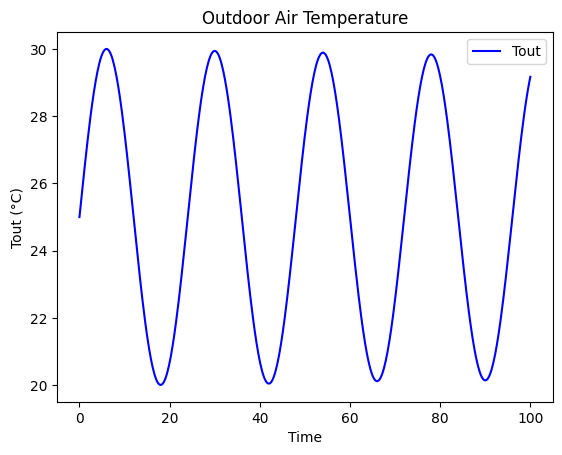

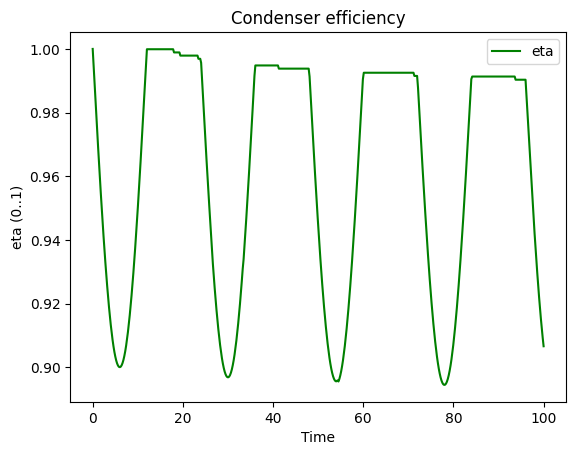

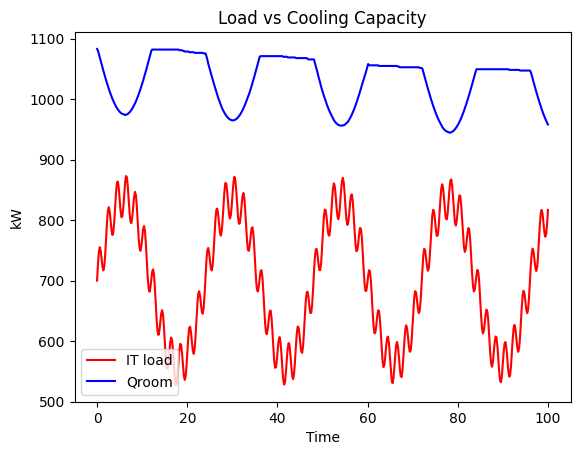

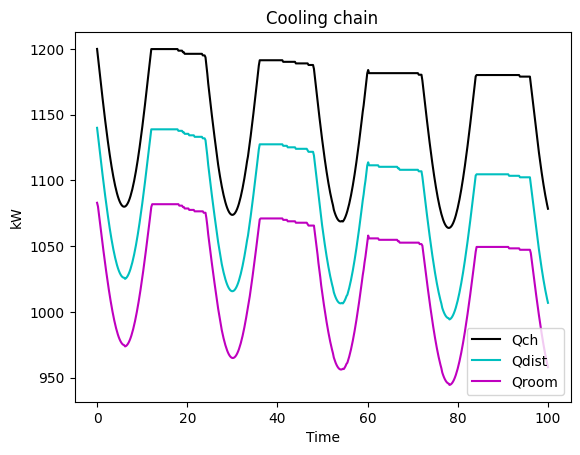

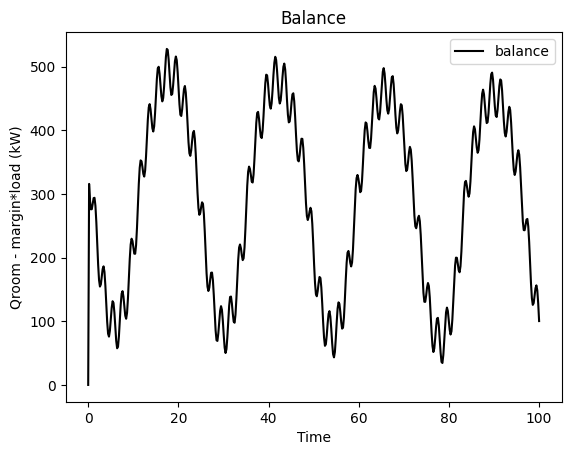

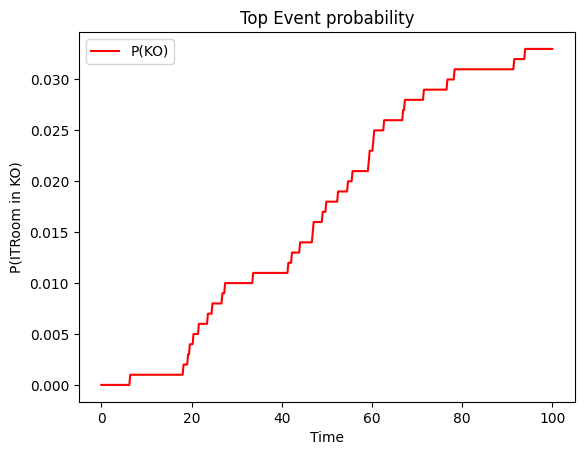

In [13]:
run()